# Topic Modeling using BERT

- BERTopic: https://maartengr.github.io/BERTopic/api/bertopic.html
- Author name: Xiao Liu
- Revised Date: Feb. 20
- Instance type: T4 GPU


# Bidirectional Encoder Representations from Transformers (BERT)

BERT stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.


# Load Data - ABC News Sample dataset

- https://www.kaggle.com/datasets/bansodesandeep/abc-news-sample

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install seaborn
!pip install numpy==1.26.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 633.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 30.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.18 requires numpy<2,>=1.26.4; python_version < "3.12", but you have numpy 1.26.1 which is incompatible.


In [4]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/abcnews_sample.csv')

Mounted at /content/drive


In [5]:
data.head()

publish_date                                   headline_text
0      20050627     lawyer claims aust govt has abandoned corby
1      20051206  singapore tells spouses of patients hiv status
2      20141119      iron ore price slumps to new five year low
3      20060203   youth crime prevention schemes share in funds
4      20190521          harry triguboff speaks to the business

In [6]:
# Create a new column containing the length each headline text
data["headline_text_len"] = data["headline_text"].apply(lambda x : len(x.split()))

In [7]:
data_text = data[['headline_text']];

In [8]:
print("The longest headline has: {} words".format(data.headline_text_len.max()))

The longest headline has: 13 words


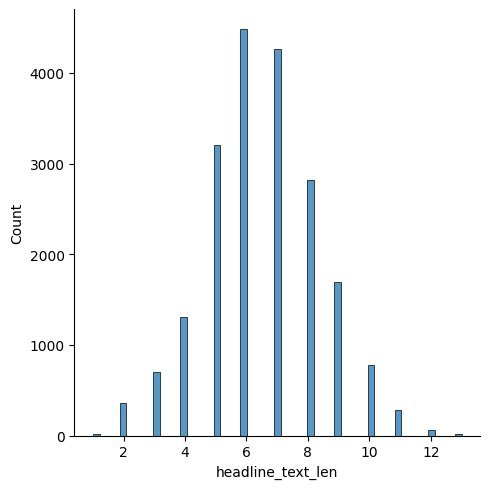

In [9]:
# Visualize the length distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data.headline_text_len, kde=False)

In [10]:
for idx in data.sample(3).index:
    headline = data.iloc[idx]
    print("Headline #{}:".format(idx))
    print("Publication date: {}".format(headline.publish_date))
    print("Text: {}\n".format(headline.headline_text))

Headline #8204:
Publication date: 20110809
Text: residents to get flood mitigation briefing

Headline #15465:
Publication date: 20090310
Text: youtube unplugs uk music clips

Headline #2420:
Publication date: 20090219
Text: tass heidi farm cheese wins top award



# Training

We start by instantiating BERTopic. We set language to english since our documents are in the English language. If you would like to use a multi-lingual model, please use language="multilingual" instead.

We will also calculate the topic probabilities. However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model.

In [11]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5

BERTopic is a topic modeling technique that leverages BERT embeddings and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

The default embedding model is all-MiniLM-L6-v2 when selecting language="english" and paraphrase-multilingual-MiniLM-L12-v2 when selecting language="multilingual".

Documentation: https://maartengr.github.io/BERTopic/api/bertopic.html

In [12]:
import os
os.environ['TOKENIZERS_PARALLELISM']='true'

In [13]:
%%time
%matplotlib notebook
from bertopic import BERTopic
model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 7, calculate_probabilities=True)
topics, probs = model.fit_transform(data.headline_text)

2025-02-21 03:44:27,762 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2025-02-21 03:44:47,615 - BERTopic - Embedding - Completed ✓
2025-02-21 03:44:47,616 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-21 03:45:25,629 - BERTopic - Dimensionality - Completed ✓
2025-02-21 03:45:25,631 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-21 03:49:00,113 - BERTopic - Cluster - Completed ✓
2025-02-21 03:49:00,129 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-21 03:49:00,653 - BERTopic - Representation - Completed ✓


CPU times: user 4min 49s, sys: 8.44 s, total: 4min 58s
Wall time: 5min 22s


In [14]:
model.get_topic_info()

Topic  Count                                        Name  \
0       -1   8280                             -1_in_to_for_of   
1        0    314          0_fire_bushfire_firefighters_fires   
2        1    211             1_interview_extended_brett_ivan   
3        2    172         2_coronavirus_covid_19_restrictions   
4        3    165            3_hospital_doctors_doctor_health   
..     ...    ...                                         ...   
445    444      7               444_eels_broncos_meyers_maika   
446    445      7  445_firebirds_swifts_thunderbirds_kestrels   
447    446      7            446_airport_bussing_fligh_panned   
448    447      7         447_fake_counterfeiters_fakes_greed   
449    448      7            448_carbon_wong_charcoal_biloela   

                                        Representation  \
0    [in, to, for, of, after, on, over, the, says, ...   
1    [fire, bushfire, firefighters, fires, bushfire...   
2    [interview, extended, brett, ivan, nathan, and...   
3    [coronavirus, covid, 19, restrictions, cases, ...   
4    [hospital, doctors, doctor, health, hospitals,...   
..                                                 ...   
445  [eels, broncos, meyers, maika, 58, sivo, eke, ...   
446  [firebirds, swifts, thunderbirds, kestrels, on...   
447  [airport, bussing, fligh, panned, fog, boosted...   
448  [fake, counterfeiters, fakes, greed, cash, das...   
449  [carbon, wong, charcoal, biloela, nationwide, ...   

                                   Representative_Docs  
0    [emergency services make christmas road safety...  
1    [homes threatened by vic bushfire, queensland ...  
2    [extended interview with john coates, intervie...  
3    [south australia records two new coronavirus c...  
4    [nt facing doctor shortage ama, health service...  
..                                                 ...  
445  [nrl luke lewis parramatta eels maika sivo jos...  
446  [swifts phoenix thunderbirds register wins, fi...  
447  [broome airport report suggests resources sect...  
448  [fake reviews online hurting businesses consum...  
449  [canada to impose nationwide carbon price, won...  

[450 rows x 5 columns]

In [15]:
model.get_topic(0)

[('fire', 0.05308279191562903),
 ('bushfire', 0.04943773709978101),
 ('firefighters', 0.03211007483095563),
 ('fires', 0.02521031888303185),
 ('bushfires', 0.02236400166586519),
 ('crews', 0.02010802478903592),
 ('homes', 0.016238036874657386),
 ('burning', 0.014956759126611348),
 ('blaze', 0.013770651571861702),
 ('firefighter', 0.012569082739189245)]

In [16]:
model.get_document_info(data.headline_text)

Document  Topic  \
0            lawyer claims aust govt has abandoned corby     -1   
1         singapore tells spouses of patients hiv status    406   
2             iron ore price slumps to new five year low    201   
3          youth crime prevention schemes share in funds     -1   
4                 harry triguboff speaks to the business     28   
...                                                  ...    ...   
19995         tourist numbers down 20 percent in top end     20   
19996  majority of emergency beacon activations last ...    264   
19997           livingstone pokie reform is about people    336   
19998                       tree clearing heats up labor     33   
19999                    john whitby kameruka retirement    183   

                                          Name  \
0                              -1_in_to_for_of   
1            406_hiv_acrobat_infector_lawmaker   
2                    201_ore_iron_price_nickel   
3                              -1_in_to_for_of   
4                28_speaks_matt_schubert_brann   
...                                        ...   
19995      20_tourism_tourist_numbers_tourists   
19996       264_emergency_beacon_response_lawn   
19997            336_pokie_pokies_wilkie_clubs   
19998            33_timber_tree_forest_forests   
19999  183_retirement_retires_retire_announces   

                                          Representation  \
0      [in, to, for, of, after, on, over, the, says, ...   
1      [hiv, acrobat, infector, lawmaker, transmissio...   
2      [ore, iron, price, nickel, asx, metals, lamber...   
3      [in, to, for, of, after, on, over, the, says, ...   
4      [speaks, matt, schubert, brann, steven, busine...   
...                                                  ...   
19995  [tourism, tourist, numbers, tourists, boost, o...   
19996  [emergency, beacon, response, lawn, interpreti...   
19997  [pokie, pokies, wilkie, clubs, needy, undemocr...   
19998  [timber, tree, forest, forests, forestry, plan...   
19999  [retirement, retires, retire, announces, retir...   

                                     Representative_Docs  \
0      [emergency services make christmas road safety...   
1      [man accused of spreading hiv takes stand, acr...   
2      [iron ore price slumps to new five year low, c...   
3      [emergency services make christmas road safety...   
4      [james mckenzie speaks to the business, steven...   
...                                                  ...   
19995  [central qld tourism leader quits, station tou...   
19996  [public meeting discusses emergency dept futur...   
19997  [pokies reform undemocratic says clubs head, w...   
19998  [union fears timber industry water penalties, ...   
19999  [peter siddle announces retirement from intern...   

                                             Top_n_words  Probability  \
0      in - to - for - of - after - on - over - the -...     0.738727   
1      hiv - acrobat - infector - lawmaker - transmis...     1.000000   
2      ore - iron - price - nickel - asx - metals - l...     0.079267   
3      in - to - for - of - after - on - over - the -...     0.750482   
4      speaks - matt - schubert - brann - steven - bu...     1.000000   
...                                                  ...          ...   
19995  tourism - tourist - numbers - tourists - boost...     0.002677   
19996  emergency - beacon - response - lawn - interpr...     0.086637   
19997  pokie - pokies - wilkie - clubs - needy - unde...     0.087906   
19998  timber - tree - forest - forests - forestry - ...     0.032599   
19999  retirement - retires - retire - announces - re...     0.436640   

       Representative_document  
0                        False  
1                        False  
2                         True  
3                        False  
4                        False  
...                        ...  
19995                    False  
19996                     True  
19997                    F

In [17]:
topics[:5]

[-1, 406, 201, -1, 28]

In [18]:
probs[:5]

array([[4.30627877e-004, 3.77456628e-004, 2.15201150e-004, ...,
        5.43992723e-004, 2.05039874e-003, 4.43783132e-004],
       [6.38514384e-307, 5.09541952e-307, 4.18197467e-307, ...,
        7.27915107e-307, 1.17350010e-306, 5.09628825e-307],
       [7.43287182e-004, 4.76136766e-004, 4.42832162e-004, ...,
        9.35024838e-004, 8.81178244e-004, 1.91830214e-003],
       [4.45983192e-004, 3.27771294e-004, 2.08878143e-004, ...,
        5.77645879e-004, 9.52377649e-004, 3.65278262e-004],
       [3.50896870e-307, 3.92748391e-306, 3.35002486e-307, ...,
        4.37263735e-307, 5.29338604e-307, 4.37982771e-307]])

## Topic Reduction after training

In [19]:
model.reduce_topics(data.headline_text, nr_topics=20)

2025-02-21 03:49:02,881 - BERTopic - Topic reduction - Reducing number of topics
2025-02-21 03:49:03,127 - BERTopic - Topic reduction - Reduced number of topics from 450 to 20


In [20]:
topics = model.topics_

In [21]:
topics[:10]

[-1, 2, 1, -1, 5, 1, 3, 2, 1, 3]

In [22]:
model.probabilities_[:10]

array([[3.31276742e-002, 2.95585197e-002, 2.90075887e-002,
        4.19029472e-002, 2.51102081e-002, 1.51601007e-002,
        1.83827258e-002, 6.59404485e-003, 1.20269502e-002,
        6.66907149e-003, 5.09523850e-003, 9.57638540e-003,
        8.33269418e-003, 4.04873385e-003, 3.08200197e-003,
        5.59719676e-003, 1.86795488e-003, 4.72925460e-003,
        1.40409134e-003],
       [4.34249522e-305, 3.67892667e-305, 1.00000000e+000,
        3.18684801e-305, 7.19658313e-305, 1.74453968e-305,
        3.06259588e-305, 9.05523320e-306, 2.00329293e-305,
        1.49691076e-305, 6.13102011e-306, 1.07097863e-305,
        7.19396144e-306, 9.74195123e-306, 3.80390297e-306,
        5.77169690e-306, 2.80139616e-306, 7.44817335e-306,
        1.54277736e-306],
       [5.96493731e-002, 1.66800850e-001, 3.25217168e-002,
        4.16362268e-002, 1.76664612e-002, 1.64522686e-002,
        1.41233270e-002, 8.32392409e-003, 1.55181275e-002,
        8.03849989e-003, 1.45766912e-002, 1.46062046e-002,
    

In [23]:
model.get_document_info(data.headline_text)

Document  Topic  \
0            lawyer claims aust govt has abandoned corby     -1   
1         singapore tells spouses of patients hiv status      2   
2             iron ore price slumps to new five year low      1   
3          youth crime prevention schemes share in funds     -1   
4                 harry triguboff speaks to the business      5   
...                                                  ...    ...   
19995         tourist numbers down 20 percent in top end      3   
19996  majority of emergency beacon activations last ...      1   
19997           livingstone pokie reform is about people     12   
19998                       tree clearing heats up labor      1   
19999                    john whitby kameruka retirement     15   

                                     Name  \
0                         -1_to_in_for_of   
1                  2_coronavirus_in_to_us   
2                   1_fire_water_to_flood   
3                         -1_to_in_for_of   
4             5_interview_speaks_abc_rudd   
...                                   ...   
19995           3_council_greens_rural_to   
19996               1_fire_water_to_flood   
19997      12_market_markets_share_shares   
19998               1_fire_water_to_flood   
19999  15_resigns_quits_farewell_appoints   

                                          Representation  \
0      [to, in, for, of, on, the, over, after, police...   
1      [coronavirus, in, to, us, china, indigenous, p...   
2      [fire, water, to, flood, for, bushfire, drough...   
3      [to, in, for, of, on, the, over, after, police...   
4      [interview, speaks, abc, rudd, abbott, turnbul...   
...                                                  ...   
19995  [council, greens, rural, to, tourism, election...   
19996  [fire, water, to, flood, for, bushfire, drough...   
19997  [market, markets, share, shares, dollar, gambl...   
19998  [fire, water, to, flood, for, bushfire, drough...   
19999  [resigns, quits, farewell, appoints, quit, app...   

                                     Representative_Docs  \
0      [man to spend nearly four years in jail over, ...   
1      [singapore coronavirus update travel restricti...   
2      [fire threat sparks clean up call, nsw fire au...   
3      [man to spend nearly four years in jail over, ...   
4      [extended interview jim middleton speaks with,...   
...                                                  ...   
19995  [national rural news, national rural news, nat...   
19996  [fire threat sparks clean up call, nsw fire au...   
19997  [australian share market edges higher, share m...   
19998  [fire threat sparks clean up call, nsw fire au...   
19999  [palios resigns as fa chief executive, victori...   

                                             Top_n_words  Probability  \
0      to - in - for - of - on - the - over - after -...     0.738727   
1      coronavirus - in - to - us - china - indigenou...     1.000000   
2      fire - water - to - flood - for - bushfire - d...     0.166801   
3      to - in - for - of - on - the - over - after -...     0.750482   
4      interview - speaks - abc - rudd - abbott - tur...     1.000000   
...                                                  ...          ...   
19995  council - greens - rural - to - tourism - elec...     0.041527   
19996  fire - water - to - flood - for - bushfire - d...     0.246619   
19997  market - markets - share - shares - dollar - g...     0.114909   
19998  fire - water - to - flood - for - bushfire - d...     0.162959   
19999  resigns - quits - farewell - appoints - quit -...     0.445617   

       Representative_document  
0                        False  
1                        False  
2                        False  
3                        False  
4                        False  
...                        ...  
19995                    False  
19996                    False  
19997                    False  
19998                    False  
19999               

# Topic Extraction and Representation

In [24]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq.head()

Number of topics: 20


Topic  Count                       Name  \
0     -1   8280            -1_to_in_for_of   
1      0   1945             0_to_for_in_of   
2      1   1839      1_fire_water_to_flood   
3      2   1506     2_coronavirus_in_to_us   
4      3   1162  3_council_greens_rural_to   

                                      Representation  \
0  [to, in, for, of, on, the, over, after, police...   
1  [to, for, in, of, on, the, cattle, win, austra...   
2  [fire, water, to, flood, for, bushfire, drough...   
3  [coronavirus, in, to, us, china, indigenous, p...   
4  [council, greens, rural, to, tourism, election...   

                                 Representative_Docs  
0  [man to spend nearly four years in jail over, ...  
1  [second ashes test day two summary, first ashe...  
2  [fire threat sparks clean up call, nsw fire au...  
3  [singapore coronavirus update travel restricti...  
4  [national rural news, national rural news, nat...

The above table has 3 main columns, providing information about all the topics in descending order of topics size/Count.

'Topic' is the topic number, a kind of identifier, and the outliers are labeled as -1. Those are topics that should be ignored because they do not bring any added value.
'Count' is the number of words in the topic.
Name is the name given to the topic.
For each topic, we can retrieve the top words and their corresponding c-TF-IDF score. The higher the score, the most relevant the word is in representing the topic.

In [25]:
a_topic = freq.iloc[1]["Topic"] # Select the 1st topic
model.get_topic(a_topic) # Show the words and their c-TF-IDF scores

[('to', 0.030334039874219933),
 ('for', 0.022258926820490813),
 ('in', 0.021796641142200573),
 ('of', 0.01906185176881758),
 ('on', 0.017076543895697755),
 ('the', 0.017045028136484026),
 ('cattle', 0.017018283000767985),
 ('win', 0.015911292602559808),
 ('australia', 0.015864118383918324),
 ('afl', 0.015711180830174868)]

From this topic, we observe that all the words are coherent for the underlying topic which seems to be about accidents.

# Topics Visualization.

The topic visualization helps in gaining more insight about each topic. BERTopic provides several visualization possibilities such as terms visualization, intertopic distance map, topic hierarchy clustering just to name a few, and our focus will be on those that have been cited.



In [26]:
import plotly.io as pio

# Set the default renderer for Jupyter
pio.renderers.default = 'colab'  # Or try 'plotly_mimetype', 'browser', or 'colab' if needed

## Topic Terms
The most relevant words of each topic can be visualized in a form of barchart out of the c-TF-IDF score, which is interesting to visually compare topics. Below is the corresponding visualization for the topic 6 topics.

In [27]:
# Visualize the barchart
fig = model.visualize_barchart(top_n_topics=10, n_words=10, height=500)
# Display the figure explicitly
fig.show()

#model.visualize_barchart(top_n_topics=10,n_words=10,height = 500)

## Intertopic Distance Map
For those who are fimiliar with Latent Dirichlet Allocation LDAvis library.

This library provides the user with an interactive dashboard showing for each topic the corresponding words and their score.

BERTopic does the same with its visualize_topics() function and even go one step further by giving the distance between topics (the lower the most similar), and all of this with a single function visualize_topics()

In [28]:
# Visualize the barchart
fig = model.visualize_topics(top_n_topics=10)

# Display the figure explicitly
fig.show()


## Visualize Topic Hierarchy¶
As you can see in the Interdistance topic dashboard, some topics are very close.

One thing that could come to mind is how can I reduce the number of topics?

The good news is that those topics can be hierarchically in order to select the appropriate number of topics. The visualization flavor helps to understand how they relate to one another.

In [29]:
# Visualize the barchart
fig = model.visualize_hierarchy(top_n_topics=30)

# Display the figure explicitly
fig.show()


By looking at the first level (level 0) of the dendogram, we can see that topics with the same colors have been grouped together.

All these information can help the user better understand the reason why the topics have been considered to be similar one to another.

## Visualize Documents and Topics
Visualize documents and their topics in 2D


In [30]:
# Visualize the barchart
fig = model.visualize_documents(data.headline_text)

# Display the figure explicitly
fig.show()


In [31]:
# Visualize the barchart
hierarchical_topics = model.hierarchical_topics(data.headline_text)
fig=model.visualize_hierarchical_documents(data.headline_text, hierarchical_topics)

# Display the figure explicitly
fig.show()


100%|██████████| 18/18 [00:00<00:00, 106.29it/s]


# Search Topics
Once the topic model is trained, we can search for topics that are semantically similar to an input query word/term using the find_topics function. In our case, we can search for top 3 topics that are related to the word 'politics'

In [32]:
# Select most 3 similar topics
similar_topics, similarity = model.find_topics("politics", top_n = 3)

similar_topics contains the topics index from most similar to least similar.
similarity contains the similarity scores in descending order.

In [33]:
similar_topics

[3, 5, 2]

In [34]:
most_similar = similar_topics[0]
print("The Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

The Most Similar Topic Info: 
[('council', 0.039443456674669225), ('greens', 0.03806010765769725), ('rural', 0.036140905045944124), ('to', 0.03549978754487866), ('tourism', 0.03506344355531339), ('election', 0.03113575286010461), ('housing', 0.03105107188257313), ('for', 0.026303580405778147), ('budget', 0.02326490612584779), ('murray', 0.022495100456054355)]
Similarity Score: 0.40253019219936925


# Topic Modeling with UMAP
BERTopic model by default produces different results each time because of the stochasticity inherited from UMAP.


Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction.


To get reproducible topics, we need to pass a value to the random_state parameter in the UMAP method.

- n_neighbors=15 means that the local neighborhood size for UMAP is 15. This is the parameter that controls the local versus global structure in data.

A low value forces UMAP to focus more on local structure, and may lose insights into the big picture.

A high value pushes UMAP to look at the broader neighborhood, and may lose details on local structure.

The default n_neighbors values for UMAP is 15.

- n_components=5 indicates that the target dimension from UMAP is 5. This is the dimension of data that will be passed into the clustering model.

- min_dist controls how tightly UMAP is allowed to pack points together. It's the minimum distance between points in the low dimensional space.

Small values of min_dist result in clumpier embeddings, which is good for clustering. Since our goal of dimension reduction is to build clustering models, we set min_dist to 0.

Large values of min_dist prevent UMAP from packing points together and preserves the broad structure of data.

- metric='cosine' indicates that we will use cosine to measure the distance.
random_state sets a random seed to make the UMAP results reproducible.

After initiating the UMAP model, we pass it to the BERTopic model, set the language to English, and set the calculate_probabilities parameter to True.

Finally, we pass the processed review documents to the topic model and saved the results for topics and topic probabilities.

The values in topics represents the topic each document is assigned to.
The values in probabilities represents the probability of a document belongs to each of the topics.

In [35]:
from umap import UMAP
# Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)
# Initiate BERTopic
model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
# Run BERTopic model
headline_topics, probabilities = model.fit_transform(data.headline_text)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [36]:
headline_topics[:5]

[-1, -1, 210, -1, 1]

In [37]:
probabilities[:5]

array([[4.35969101e-004, 4.22232469e-004, 5.20530829e-004, ...,
        1.67729504e-004, 3.95836208e-004, 3.66508462e-004],
       [1.92046128e-003, 1.59833497e-003, 3.13348284e-003, ...,
        9.07281650e-004, 1.44871616e-003, 1.45967147e-003],
       [2.58238391e-307, 2.56111179e-307, 2.64626945e-307, ...,
        2.87416292e-307, 3.75388646e-307, 2.27373990e-307],
       [1.01882030e-003, 6.93985242e-004, 1.48927890e-003, ...,
        3.63427055e-004, 7.47630987e-004, 6.30502628e-004],
       [2.16337825e-307, 1.00000000e+000, 2.29452214e-307, ...,
        1.97946267e-307, 2.80199500e-307, 1.52001445e-306]])

In [38]:
model.get_topic_info()

Topic  Count                                    Name  \
0       -1   8483                     -1_police_to_for_of   
1        0    416             0_fire_bushfire_blaze_fires   
2        1    386       1_interview_speaks_extended_media   
3        2    248              2_crash_dies_plane_crashes   
4        3    247             3_iraq_baghdad_iraqi_afghan   
..     ...    ...                                     ...   
273    272     10  272_workcover_workers_component_tuppal   
274    273     10        273_mma_wrestling_dumbed_mysuper   
275    274     10        274_rural_news_thursday_national   
276    275     10         275_sheep_unloaded_staged_lambs   
277    276     10              276_smith_norm_kicked_weve   

                                        Representation  \
0    [police, to, for, of, in, over, the, man, on, ...   
1    [fire, bushfire, blaze, fires, firefighters, b...   
2    [interview, speaks, extended, media, smith, lu...   
3    [crash, dies, plane, crashes, truck, dead, car...   
4    [iraq, baghdad, iraqi, afghan, kills, taliban,...   
..                                                 ...   
273  [workcover, workers, component, tuppal, ambigu...   
274  [mma, wrestling, dumbed, mysuper, necessity, u...   
275  [rural, news, thursday, national, capricornia,...   
276  [sheep, unloaded, staged, lambs, unsold, modia...   
277  [smith, norm, kicked, weve, pickett, lone, beg...   

                                   Representative_Docs  
0    [family of hit and run victim hope driver can ...  
1    [bushfire threatens sydney homes, nsw fire cre...  
2    [interview steve smith, interview steve smith,...  
3    [woman dies in pacific highway crash, man dies...  
4    [children killed in afghan suicide blast, iraq...  
..                                                 ...  
273  [contractor handbook to remove ambiguity, work...  
274  [controversy over transgender wrestling champi...  
275  [national rural news for thursday, national ru...  
276  [4 producers views on record sheep prices, mod...  
277  [brumbies smith to face court on two charges, ...  

[278 rows x 5 columns]

In [39]:
model.get_document_info(data.headline_text)

Document  Topic  \
0            lawyer claims aust govt has abandoned corby     -1   
1         singapore tells spouses of patients hiv status     -1   
2             iron ore price slumps to new five year low    210   
3          youth crime prevention schemes share in funds     -1   
4                 harry triguboff speaks to the business      1   
...                                                  ...    ...   
19995         tourist numbers down 20 percent in top end     35   
19996  majority of emergency beacon activations last ...      0   
19997           livingstone pokie reform is about people    234   
19998                       tree clearing heats up labor     26   
19999                    john whitby kameruka retirement     -1   

                                    Name  \
0                    -1_police_to_for_of   
1                    -1_police_to_for_of   
2                 210_ore_iron_price_asx   
3                    -1_police_to_for_of   
4      1_interview_speaks_extended_media   
...                                  ...   
19995  35_tourism_easter_numbers_outback   
19996        0_fire_bushfire_blaze_fires   
19997      234_pokies_pokie_wilkie_clubs   
19998      26_forest_tree_timber_logging   
19999                -1_police_to_for_of   

                                          Representation  \
0      [police, to, for, of, in, over, the, man, on, ...   
1      [police, to, for, of, in, over, the, man, on, ...   
2      [ore, iron, price, asx, wpg, lambert, benchmar...   
3      [police, to, for, of, in, over, the, man, on, ...   
4      [interview, speaks, extended, media, smith, lu...   
...                                                  ...   
19995  [tourism, easter, numbers, outback, tourist, t...   
19996  [fire, bushfire, blaze, fires, firefighters, b...   
19997  [pokies, pokie, wilkie, clubs, porkies, favour...   
19998  [forest, tree, timber, logging, hazelwood, for...   
19999  [police, to, for, of, in, over, the, man, on, ...   

                                     Representative_Docs  \
0      [family of hit and run victim hope driver can ...   
1      [family of hit and run victim hope driver can ...   
2      [iron ore price slumps to new five year low, c...   
3      [family of hit and run victim hope driver can ...   
4      [interview steve smith, interview steve smith,...   
...                                                  ...   
19995  [call for country tourism boost, mixed respons...   
19996  [bushfire threatens sydney homes, nsw fire cre...   
19997  [wilkie responds to abbotts pokie stance, wilk...   
19998  [business support for forest mine plan, forest...   
19999  [family of hit and run victim hope driver can ...   

                                             Top_n_words  Probability  \
0      police - to - for - of - in - over - the - man...     0.840201   
1      police - to - for - of - in - over - the - man...     0.276402   
2      ore - iron - price - asx - wpg - lambert - ben...     1.000000   
3      police - to - for - of - in - over - the - man...     0.653762   
4      interview - speaks - extended - media - smith ...     1.000000   
...                                                  ...          ...   
19995  tourism - easter - numbers - outback - tourist...     0.356301   
19996  fire - bushfire - blaze - fires - firefighters...     0.005360   
19997  pokies - pokie - wilkie - clubs - porkies - fa...     1.000000   
19998  forest - tree - timber - logging - hazelwood -...     0.019758   
19999  police - to - for - of - in - over - the - man...     0.645018   

       Representative_document  
0                        False  
1                        False  
2                         True  
3                        False  
4                        False  
...                        ...  
19995                    False  
19996                    False  
19997                    False  
19998                    False  
19999                    False  

In [40]:
# Visualize the barchart
fig = model.visualize_barchart(top_n_topics=10,n_words=10,height = 500)
# Display the figure explicitly
fig.show()


In [41]:
# Visualize the barchart
fig = model.visualize_topics(top_n_topics=20)
# Display the figure explicitly
fig.show()

In [42]:
model.probabilities_[0]

array([0.00043597, 0.00042223, 0.00052053, 0.00045414, 0.00063356,
       0.00090987, 0.00038063, 0.00051916, 0.00037162, 0.00089406,
       0.00060583, 0.00042903, 0.00146209, 0.00035437, 0.00038697,
       0.0004665 , 0.00037114, 0.00045697, 0.00072238, 0.00042518,
       0.00050438, 0.00031231, 0.00092286, 0.00049509, 0.00040527,
       0.00035679, 0.00051322, 0.00044256, 0.00038916, 0.00052167,
       0.00044598, 0.00070723, 0.00072607, 0.00061289, 0.00102256,
       0.00074111, 0.00061115, 0.00053816, 0.00036321, 0.00052233,
       0.00046631, 0.00062286, 0.00027182, 0.00040558, 0.00043209,
       0.00047794, 0.00042437, 0.00040502, 0.00067678, 0.0010016 ,
       0.00039767, 0.00070597, 0.00060603, 0.0006255 , 0.00052455,
       0.00031035, 0.00050991, 0.0003593 , 0.00091061, 0.00082046,
       0.00054005, 0.00059635, 0.00055019, 0.00033479, 0.00044011,
       0.00053381, 0.00059615, 0.00036628, 0.00064548, 0.00068544,
       0.00055103, 0.00038938, 0.00089001, 0.00034755, 0.00077

# Zero shot Topic Modeling

Zero-shot Topic Modeling is a technique that allows you to find topics in large amounts of documents that were predefined. When faced with many documents, you often have an idea of which topics will definitely be in there. Whether that is a result of simply knowing your data or if a domain expert is involved in defining those topics.


This method allows you to not only find those specific topics but also create new topics for documents that would not fit with your predefined topics. This allows for extensive flexibility as there are three scenario's to explore.

- First, both zero-shot topics and clustered topics were detected. This means that some documents would fit with the predefined topics where others would not. For the latter, new topics were found.

- Second, only zero-shot topics were detected. Here, we would not need to find additional topics since all original documents were assigned to one of the predefined topics.

- Third, no zero-shot topics were detected. This means that none of the documents would fit with the predefined topics and a regular BERTopic would be run.

Zero-shot BERTopic needs two parameters:
* zeroshot_topic_list - The names of the topics to assign documents to. Making sure this is as descriptive as possible helps improve the assignment since they are based on cosine similarities between embeddings.
* zeroshot_min_similarity - The minimum cosine similarity needed to match a document to a document. It is a value between 0 and 1.

In [43]:
from bertopic.representation import KeyBERTInspired
zeroshot_topic_list = ["politics", "global warming", "crime"]

# We fit our model using the zero-shot topics
# and we define a minimum similarity. For each document,
# if the similarity does not exceed that value, it will be used
# for clustering instead.
topic_model = BERTopic(
    embedding_model="thenlper/gte-small",
    min_topic_size=5,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.75,
    representation_model=KeyBERTInspired()
)
topics, _ = topic_model.fit_transform(data.headline_text)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [44]:
topic_model.get_topic_info()

Topic  Count                                  Name  \
0       -1   3413            -1_injured_final_world_nrl   
1        0   5437                              politics   
2        1   1341                        global warming   
3        2   4524                                 crime   
4        3     10                         3_tamworth___   
..     ...    ...                                   ...   
262    261     30  261_ashes_cricket_cricketers_wickets   
263    262      8      262_bangladesh_odis_odi_twenty20   
264    263     14             263_lanka_lankans_sri_odi   
265    264     26      264_pakistan_cricket_odi_aussies   
266    265     14  265_india_aussies_australians_indian   

                                        Representation  \
0    [injured, final, world, nrl, back, sa, austral...   
1    [rural, news, national, vote, election, poll, ...   
2    [abc, weather, forecast, climate, wind, rain, ...   
3    [arrest, arrested, stabbed, suspect, stabbing,...   
4                         [tamworth, , , , , , , , , ]   
..                                                 ...   
262  [ashes, cricket, cricketers, wickets, odi, inn...   
263  [bangladesh, odis, odi, twenty20, final, tons,...   
264   [lanka, lankans, sri, odi, final, india, , , , ]   
265  [pakistan, cricket, odi, aussies, australia, a...   
266  [india, aussies, australians, indian, innings,...   

                                   Representative_Docs  
0    [aussie pursuit team takes gold in world recor...  
1    [national rural news, aboriginal party seeks t...  
2    [abc weather, abc weather, climate change warn...  
3    [sa murder probe second arrest body found in v...  
4    [tamworth country music festival starmaker win...  
..                                                 ...  
262  [second ashes test day two summary, first ashe...  
263  [india beats bangladesh in triangular series, ...  
264  [sri lanka looking for positive start to tour,...  
265  [pakistan destroys aussie top order, pakistan ...  
266  [australia recovers on day one of second test ...  

[267 rows x 5 columns]

# Topic Modeling with Twitter US Airline Sentment Data

## Load Data
- Twitter US Airline Sentiment dataset - https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [45]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tweets.csv')
data.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

## Data Exploration

In [46]:
# Create a new column containing the length each text
data["text_len"] = data["text"].apply(lambda x : len(x.split()))
data_text = data[['text']]
print("The longest tweet has: {} words".format(data.text_len.max()))

The longest tweet has: 36 words


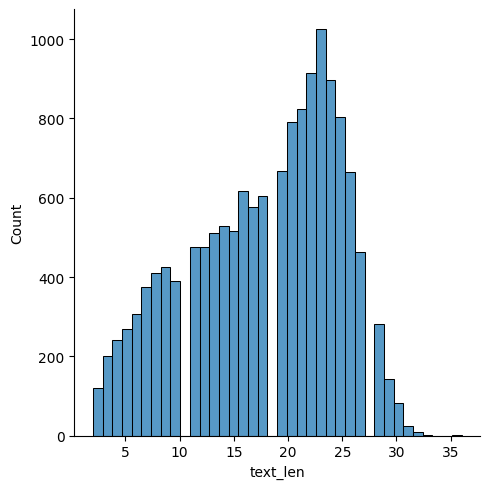

In [47]:
# Visualize the length distribution
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

sns.displot(data.text_len, kde=False)

In [48]:
for idx in data.sample(3).index:
    headline = data.iloc[idx]
    print("Headline #{}:".format(idx))
    print("Publication date: {}".format(headline.tweet_created))
    print("Text: {}\n".format(headline.text))

Headline #3114:
Publication date: 2015-02-19 22:44:45 -0800
Text: @united your staff at LaGuardia and Lagos, Nigeria were unprofessional, uncaring and not helpful. Ou

Headline #9161:
Publication date: 2015-02-23 21:22:05 -0800
Text: @USAirways Hi. I'm in LGA but my luggage is in CLT. Have been told to come back tomorrow to collect. Do you guys want to cover my taxi fare?

Headline #5191:
Publication date: 2015-02-21 14:43:34 -0800
Text: @SouthwestAir replacing @vitaminwater with beer! Bravo!👏👏 Cheers! 🍻🍻 @Leinenkugels @DosEquis @FatTire



## Build a BERTopic Model with UMAP

In [49]:
# Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)
# Initiate BERTopic
model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
# Run BERTopic model
headline_topics, probabilities = model.fit_transform(data.text)

### Get the topic information: topic index, name, and representation

In [50]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq.head()

Number of topics: 141


Topic  Count                                 Name  \
0     -1   6373              -1_united_the_to_flight   
1      0   1049           0_bag_bags_luggage_baggage   
2      1    550           1_jetblue_thanks_thank_you   
3      2    448  2_southwestair_thank_southwest_love   
4      3    286         3_usairways_thank_thanks_you   

                                      Representation  \
0  [united, the, to, flight, and, for, on, in, is...   
1  [bag, bags, luggage, baggage, lost, my, checke...   
2  [jetblue, thanks, thank, you, love, good, grea...   
3  [southwestair, thank, southwest, love, swa, th...   
4  [usairways, thank, thanks, you, me, he, it, da...   

                                 Representative_Docs  
0  [@JetBlue  thanks for response! Crew has been ...  
1  [@united where is our luggage, @USAirways wher...  
2  [@JetBlue Thanks!, @JetBlue thanks..., @JetBlu...  
3  [@SouthwestAir thank you!, @SouthwestAir thank...  
4  [@USAirways thanks., .@USAirways thanks!, @USA...

## Get the frequent words from a topic

In [51]:
a_topic = freq.iloc[1]["Topic"] # Select the 1st topic
model.get_topic(a_topic)

[('bag', 0.03216937565413614),
 ('bags', 0.02508033185752752),
 ('luggage', 0.023087910217346463),
 ('baggage', 0.019462154061946627),
 ('lost', 0.013086218271647968),
 ('my', 0.011432583726354662),
 ('checked', 0.008512414375205581),
 ('claim', 0.008195689569110166),
 ('united', 0.007287610943798999),
 ('in', 0.0071754359176574665)]

## Get the topic allocation in a specific document

In [52]:
model.probabilities_[0]

array([1.05125537e-307, 1.57699024e-307, 1.73908944e-307, 1.09565848e-307,
       1.19102382e-307, 1.71921290e-307, 9.22634406e-308, 1.60773404e-307,
       1.94952883e-307, 2.20658944e-307, 1.00000000e+000, 1.43322524e-307,
       1.04233000e-307, 1.76298444e-307, 1.71909111e-307, 1.53692786e-307,
       1.19402203e-307, 1.15963008e-307, 1.12025710e-307, 1.42939174e-307,
       1.55068135e-307, 4.19230313e-308, 1.59641917e-307, 6.10903752e-307,
       1.96432081e-307, 1.27249291e-307, 7.96887395e-308, 1.58374438e-307,
       1.64434173e-307, 1.27419806e-307, 1.09405976e-307, 9.57599389e-308,
       1.48919640e-307, 7.65245495e-308, 1.22001839e-307, 7.82814040e-308,
       1.53338336e-307, 2.04421314e-307, 1.60248540e-307, 1.10129385e-307,
       2.00870192e-307, 1.85175076e-307, 1.41070542e-307, 1.79119385e-307,
       1.22294827e-307, 1.91718555e-307, 1.37178320e-307, 1.41851419e-307,
       1.54578397e-307, 4.14519749e-308, 1.82443456e-307, 1.04652181e-307,
       1.21857607e-307, 1

# Visualize the top words from top n topics

In [53]:
# Visualize the barchart
fig = model.visualize_barchart(top_n_topics=6)
# Display the figure explicitly
fig.show()


## Visualize the distance among topics

In [54]:
# Visualize the barchart
fig = model.visualize_topics(top_n_topics=6)

# Display the figure explicitly
fig.show()


##Visualize the topic hierarchy

In [55]:
# Visualize the barchart
fig = model.visualize_hierarchy(top_n_topics=20)
# Display the figure explicitly
fig.show()


## Visualize the topic similarity

In [56]:
# Visualize the barchart
fig = model.visualize_heatmap(top_n_topics=30)
# Display the figure explicitly
fig.show()


# Visualize the topic frequency over time

---
topics_over_time(self, docs, timestamps, topics=None, nr_bins=None, datetime_format=None, evolution_tuning=True, global_tuning=True)

---
visualize_topics_over_time(self, topics_over_time, top_n_topics=None, topics=None, normalize_frequency=False, custom_labels=False, title='<b>Topics over Time</b>', width=1250, height=450)

### Visualize topic frequency for all data

In [57]:
# Adjust the format to include time and timezone
data['tweet_created_format'] = pd.to_datetime(data['tweet_created'], format='%Y-%m-%d %H:%M:%S %z')

# Create topics over time
topics_over_time = model.topics_over_time(data.text, timestamps=data['tweet_created_format'], nr_bins=20)


In [58]:
model.visualize_topics_over_time(topics_over_time, topics = [0, 1, 2, 3, 4, 5])

### Visualize topic frequency for a specific airline


In [59]:
#Create topics over time
virgin= data[data['airline']=='Virgin America']
va_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
# Run BERTopic model
topics, probabilities = va_model.fit_transform(virgin.text)
topics_over_time = va_model.topics_over_time(virgin.text, timestamps=virgin.tweet_created_format, nr_bins=20)
va_model.visualize_topics_over_time(topics_over_time, topics = [0, 1, 2, 3, 4, 5])

## Visualize the topic per sentiment classes


---
topics_per_class(self, docs, classes, global_tuning=True)


---

visualize_topics_per_class(self, topics_per_class, top_n_topics=10, topics=None, normalize_frequency=False, custom_labels=False, title='<b>Topics per Class</b>', width=1250, height=900)

### Visualize the topic per class for the entire dataset

In [60]:
# Or try 'plotly_mimetype', 'browser', or 'colab' if needed

docs=data['text']
classes=data['airline_sentiment']
#Create topics per class
topics_per_class = model.topics_per_class(docs, classes=classes)

# Visualize the barchart
fig = model.visualize_topics_per_class(topics_per_class)

# Display the figure explicitly
fig.show()


### Visualize topic per class for a specific airline

In [61]:
# Visualize the barchart
va_topic_per_class = va_model.topics_per_class(virgin.text, classes=virgin.airline_sentiment)

fig = va_model.visualize_topics_per_class(va_topic_per_class)

# Display the figure explicitly
fig.show()


# Conclusion
Now, you know how to use BERTopic for topic modeling. The results are very encouraging, and do not hesitate to give it a try on your business case. However, it is important to note that the results of BERTopic are not consistent between runs, this is due to the stochastic nature of UMAP used for dimensionality reduction.

So, using the random_state parameter in UMAP to account for any stochastic behavior.

Reference:
kaggle post - https://www.kaggle.com/code/bansodesandeep/topic-modeling-with-bert/notebook